In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

import xgboost as xgb

In [2]:
#Read dataset
df = pd.read_csv("/content/heart (1).csv")


In [3]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,1025.000000,1025.000000,1025.000000,1025.000000,1025.00000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000
mean,54.434146,0.695610,0.942439,131.611707,246.00000,0.149268,0.529756,149.114146,0.336585,1.071512,1.385366,0.754146,2.323902,0.513171
std,9.072290,0.460373,1.029641,17.516718,51.59251,0.356527,0.527878,23.005724,0.472772,1.175053,0.617755,1.030798,0.620660,0.500070
min,29.000000,0.000000,0.000000,94.000000,126.00000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,0.000000,0.000000,120.000000,211.00000,0.000000,0.000000,132.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,56.000000,1.000000,1.000000,130.000000,240.00000,0.000000,1.000000,152.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,275.00000,0.000000,1.000000,166.000000,1.000000,1.800000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.00000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


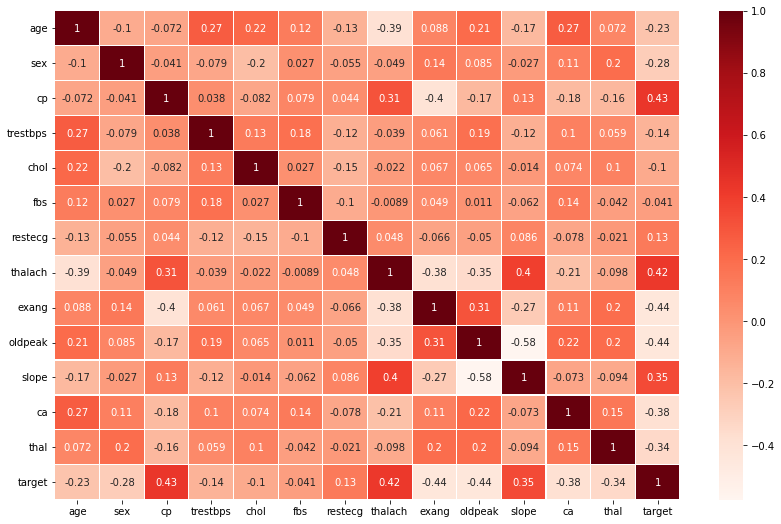

In [4]:
plt.figure(figsize=(14, 9))
sns.heatmap(df.corr(), annot=True, cmap='Reds', linewidths=0.1)

In [5]:
#Target Distribution
df.target.value_counts()

1    526
0    499
Name: target, dtype: int64

In [6]:
#feature to be scaled
features_to_be_scaled = [feature for feature in df.columns if len(df[feature].unique()) < 10]
features_to_be_scaled.remove('target')
print('No of features to be scaled: {}'.format(len(features_to_be_scaled)))

No of features to be scaled: 8


In [7]:
features_to_be_scaled

['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

In [8]:
#one hot encoding
temp_df = pd.get_dummies(df, columns=features_to_be_scaled)
std = StandardScaler()
temp_df[['age', 'trestbps', 'chol', 'thalach', 'oldpeak']] = std.fit_transform(temp_df[['age', 'trestbps', 'chol', 'thalach', 'oldpeak']])

In [9]:
temp_df

,age,trestbps,chol,thalach,oldpeak,target,sex_0,sex_1,cp_0,cp_1,...,slope_2,ca_0,ca_1,ca_2,ca_3,ca_4,thal_0,thal_1,thal_2,thal_3
0,-0.268437,-0.377636,-0.659332,0.821321,-0.060888,0,0,1,1,0,...,1,0,0,1,0,0,0,0,0,1
1,-0.158157,0.479107,-0.833861,0.255968,1.727137,0,0,1,1,0,...,0,1,0,0,0,0,0,0,0,1
2,1.716595,0.764688,-1.396233,-1.048692,1.301417,0,0,1,1,0,...,0,1,0,0,0,0,0,0,0,1
3,0.724079,0.936037,-0.833861,0.516900,-0.912329,0,0,1,1,0,...,1,0,1,0,0,0,0,0,0,1
4,0.834359,0.364875,0.930822,-1.874977,0.705408,0,1,0,1,0,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,0.503520,0.479107,-0.484803,0.647366,-0.912329,1,0,1,0,1,...,1,1,0,0,0,0,0,0,1,0
1021,0.613800,-0.377636,0.232705,-0.352873,1.471705,0,0,1,1,0,...,0,0,1,0,0,0,0,0,0,1
1022,-0.819834,-1.234378,0.562371,-1.353113,-0.060888,0,0,1,1,0,...,0,0,1,0,0,0,0,0,1,0
1023,-0.488996,-1.234378,0.155137,0.429923,-0.912329,1,1,0,1,0,...,1,1,0,0,0,0,0,0,1,0


In [10]:
y = temp_df.target
X = temp_df.drop(["target"], axis=1)

In [11]:
#training and testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [12]:
X_train

,age,trestbps,chol,thalach,oldpeak,sex_0,sex_1,cp_0,cp_1,cp_2,...,slope_2,ca_0,ca_1,ca_2,ca_3,ca_4,thal_0,thal_1,thal_2,thal_3
25,0.724079,0.764688,1.182919,-0.135430,-0.060888,1,0,1,0,0,...,0,1,0,0,0,0,0,0,0,1
72,0.172682,-0.377636,0.058176,-0.222407,0.109400,0,1,1,0,0,...,0,0,1,0,0,0,0,0,1,0
532,0.944639,-0.434752,-0.950214,-0.570317,-0.912329,1,0,1,0,0,...,0,1,0,0,0,0,0,0,1,0
44,0.062402,0.022178,1.861644,0.734343,0.109400,1,0,0,1,0,...,1,1,0,0,0,0,0,0,1,0
296,1.385757,-0.663216,-0.174529,-3.397080,-0.060888,0,1,1,0,0,...,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
700,-1.481512,-0.092055,-0.620548,0.821321,0.790552,0,1,0,0,1,...,0,1,0,0,0,0,0,0,1,0
71,0.724079,0.479107,-0.756293,-0.483339,0.705408,0,1,1,0,0,...,1,0,1,0,0,0,0,0,0,1
106,-0.378716,0.479107,1.027782,1.038764,0.449976,0,1,1,0,0,...,1,1,0,0,0,0,0,0,0,1
270,-1.260953,-1.234378,-0.678724,0.516900,-0.912329,0,1,1,0,0,...,1,1,0,0,0,0,0,0,0,1


In [13]:
#hyperparameter_optimization
params={
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ],
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
    
}
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
classifier = xgb.XGBClassifier()

random_search = RandomizedSearchCV(classifier, param_distributions=params, n_iter=5, scoring='roc_auc', n_jobs=-1,cv=5,verbose=3)

random_search.fit(X_train,y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(cv=5, estimator=XGBClassifier(), n_iter=5, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.5,
                                                             0.7],
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2,
                                                          0.25, 0.3],
                                        'max_depth': [3, 4, 5, 6, 8, 10, 12,
                                                      15],
                                        'min_child_weight': [1, 3, 5, 7]},
                   scoring='roc_auc', verbose=3)

In [14]:
#cross_validation
classifier = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0.2, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, monotone_constraints='(1,-1)',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=0)

from sklearn.model_selection import cross_val_score
score = cross_val_score(classifier, X, y, cv=10)
score.mean()
classifier.fit(X_train,y_train)

XGBClassifier(colsample_bytree=0.3, gamma=0.2, gpu_id=0,
              interaction_constraints='', max_depth=6,
              monotone_constraints='(1,-1)', n_jobs=0, num_parallel_tree=1,
              tree_method='exact', validate_parameters=1, verbosity=0)

In [ ]:
score.mean()

0.9941462021701885

In [ ]:
predictions = classifier.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 98.05%


In [ ]:
from sklearn.metrics import classification_report, accuracy_score
print('\n\033[1m'+'.: Classification Report'+'\033[0m')
print('*' * 25)
print (classification_report(y_test,predictions))




.: Classification Report
*************************
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        78
           1       1.00      0.96      0.98        76

    accuracy                           0.98       154
   macro avg       0.98      0.98      0.98       154
weighted avg       0.98      0.98      0.98       154



In [ ]:
from sklearn.metrics import classification_report, accuracy_score
print('\n\033[1m'+'.: Classification Report'+'\033[0m')
print('*' * 25)
print(classification_report(y_test,predictions)






SyntaxError: ignored

<Figure size 576x396 with 0 Axes>

ConfusionMatrix(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f2ce9c472b0>,
                cmap=<matplotlib.colors.ListedColormap object at 0x7f2ce9af48e0>,
                estimator=XGBClassifier(colsample_bytree=0.3, gamma=0.2,
                                        gpu_id=0, interaction_constraints='',
                                        max_depth=6,
                                        monotone_constraints='(1,-1)', n_jobs=0,
                                        num_parallel_tree=1,
                                        tree_method='exact',
                                        validate_parameters=1, verbosity=0))

<Figure size 576x396 with 0 Axes>

In [ ]:
from sklearn.metrics import classification_report, accuracy_score
print('\n\033[1m'+'.: Classification Report'+'\033[0m')
print('*' * 25)
print(classification_report(y_test,predictions)

SyntaxError: ignored

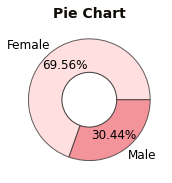

In [30]:

import matplotlib.pyplot as plt
color_mix = ['#F38BB2', '#FFB9CF', '#FFD7D7', '#F17881', '#E7525B']
black_grad = ['#100C07', '#3E3B39', '#6D6A6A', '#9B9A9C', '#CAC9CD']

labels=['Female', 'Male']
colors=color_mix[2:4]
plt.subplot(1, 2, 1)
plt.title('Pie Chart', fontweight='bold', fontsize=14,
          fontfamily='sans-serif', color=black_grad[0])
plt.pie(df['sex'].value_counts(), labels=labels, colors=colors, pctdistance=0.7,
        autopct='%.2f%%', wedgeprops=dict(alpha=0.8, edgecolor=black_grad[1]),
        textprops={'fontsize':12})
centre=plt.Circle((0, 0), 0.45, fc='white', edgecolor=black_grad[1])
plt.gcf().gca().add_artist(centre)

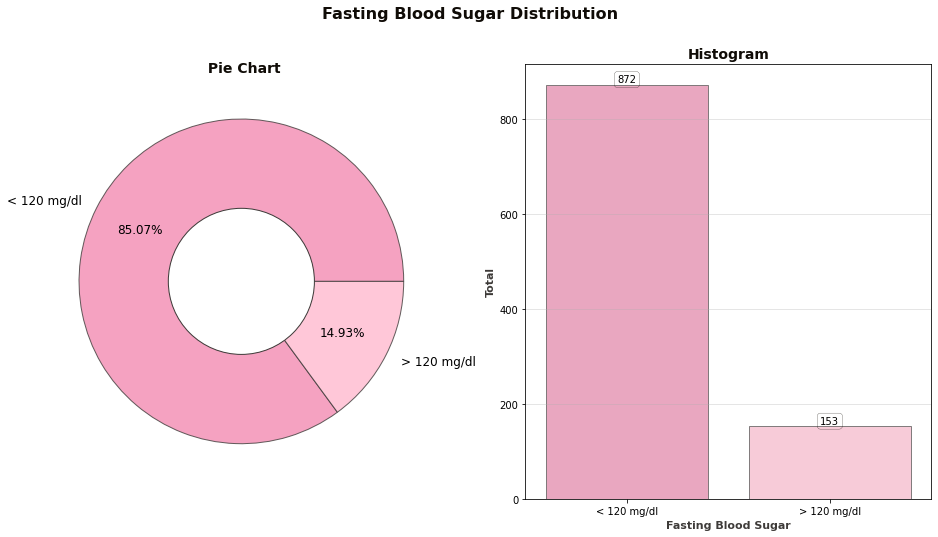

In [33]:
# --- Setting Colors, Labels, Order ---
colors=color_mix[0:2]
labels=['< 120 mg/dl', '> 120 mg/dl']
order=df['fbs'].value_counts().index

# --- Size for Both Figures ---
plt.figure(figsize=(16, 8))
plt.suptitle('Fasting Blood Sugar Distribution', fontweight='heavy', 
             fontsize=16, fontfamily='sans-serif', color=black_grad[0])

# --- Pie Chart ---
plt.subplot(1, 2, 1)
plt.title(' Pie Chart', fontweight='bold', fontsize=14, fontfamily='sans-serif', 
          color=black_grad[0])
plt.pie(df['fbs'].value_counts(), labels=labels, colors=colors,
        wedgeprops=dict(alpha=0.8, edgecolor=black_grad[1]), autopct='%.2f%%',
        pctdistance=0.7, textprops={'fontsize':12})
centre=plt.Circle((0, 0), 0.45, fc='white', edgecolor=black_grad[1])
plt.gcf().gca().add_artist(centre)

# --- Histogram ---
countplt = plt.subplot(1, 2, 2)
plt.title('Histogram', fontweight='bold', fontsize=14, fontfamily='sans-serif', 
          color=black_grad[0])
ax = sns.countplot(x='fbs', data=df, palette=colors, order=order,
                   edgecolor=black_grad[2], alpha=0.85)
for rect in ax.patches:
    ax.text (rect.get_x()+rect.get_width()/2, 
             rect.get_height()+4.25,rect.get_height(), 
             horizontalalignment='center', fontsize=10,
             bbox=dict(facecolor='none', edgecolor=black_grad[0], linewidth=0.25,
                       boxstyle='round'))

plt.xlabel('Fasting Blood Sugar', fontweight='bold', fontsize=11, 
           fontfamily='sans-serif', color=black_grad[1])
plt.ylabel('Total', fontweight='bold', fontsize=11, fontfamily='sans-serif', 
           color=black_grad[1])
plt.xticks([0, 1], labels)
plt.grid(axis='y', alpha=0.4)
countplt

# --- Count Categorical Labels w/out Dropping Null Walues ---


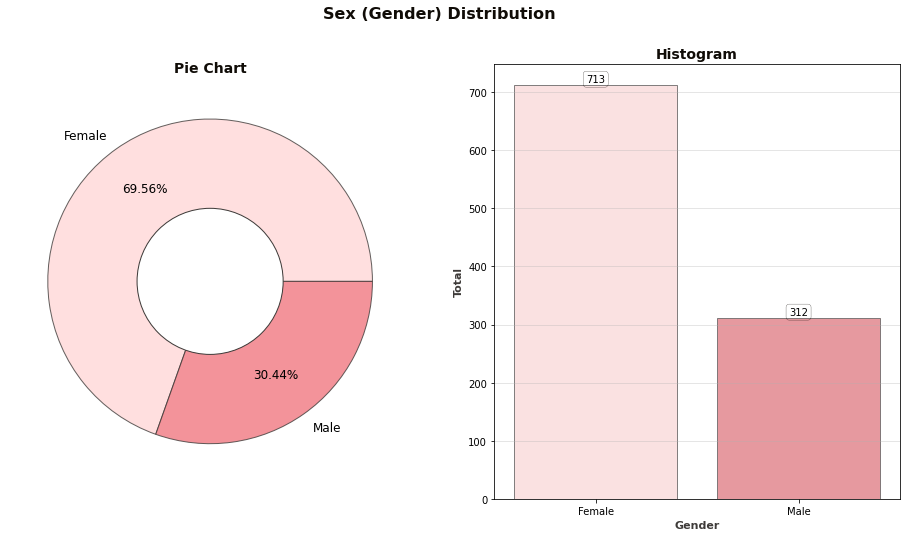

In [34]:
# --- Setting Colors, Labels, Order ---
colors=color_mix[2:4]
labels=['Female', 'Male']
order=df['sex'].value_counts().index

# --- Size for Both Figures ---
plt.figure(figsize=(16, 8))
plt.suptitle('Sex (Gender) Distribution', fontweight='heavy', 
             fontsize='16', fontfamily='sans-serif', color=black_grad[0])

# --- Pie Chart ---
plt.subplot(1, 2, 1)
plt.title('Pie Chart', fontweight='bold', fontsize=14,
          fontfamily='sans-serif', color=black_grad[0])
plt.pie(df['sex'].value_counts(), labels=labels, colors=colors, pctdistance=0.7,
        autopct='%.2f%%', wedgeprops=dict(alpha=0.8, edgecolor=black_grad[1]),
        textprops={'fontsize':12})
centre=plt.Circle((0, 0), 0.45, fc='white', edgecolor=black_grad[1])
plt.gcf().gca().add_artist(centre)

# --- Histogram ---
countplt = plt.subplot(1, 2, 2)
plt.title('Histogram', fontweight='bold', fontsize=14, 
          fontfamily='sans-serif', color=black_grad[0])
ax = sns.countplot(x='sex', data=df, palette=colors, order=order,
                   edgecolor=black_grad[2], alpha=0.85)
for rect in ax.patches:
    ax.text (rect.get_x()+rect.get_width()/2, 
             rect.get_height()+4.25,rect.get_height(), 
             horizontalalignment='center', fontsize=10, 
             bbox=dict(facecolor='none', edgecolor=black_grad[0], 
                       linewidth=0.25, boxstyle='round'))

plt.xlabel('Gender', fontweight='bold', fontsize=11, fontfamily='sans-serif', 
           color=black_grad[1])
plt.ylabel('Total', fontweight='bold', fontsize=11, fontfamily='sans-serif', 
           color=black_grad[1])
plt.xticks([0, 1], labels)
plt.grid(axis='y', alpha=0.4)
countplt

# --- Count Categorical Labels w/out Dropping Null Walues ---


TypeError: ignored

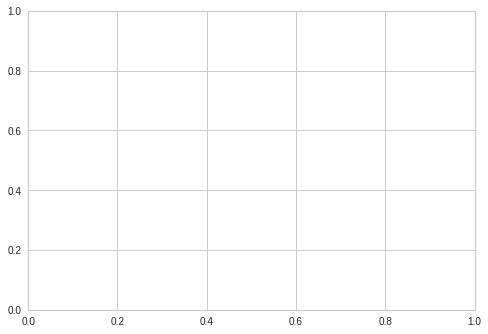

In [38]:
from yellowbrick.model_selection import LearningCurve, FeatureImportances
dtclc = LearningCurve(xgb.XGBClassifier, title=' Learning Curve')
dtclc.fit(X_train, y_train)
dtclc.finalize()
